# NIH Chest X-ray Dataset - Trained on VGG16

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.utils import shuffle

df = pd.read_csv('../input/data/Data_Entry_2017.csv')

diseases = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
#Number diseases
for disease in diseases :
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)


In [ ]:
import os
labels = df[diseases].to_numpy()
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input','data','images*','images','*.png'))}
print('Images found:', len(all_image_paths))


df['Path'] = df['Image Index'].map(all_image_paths.get)
files_list = df['Path'].tolist()

# #test to perfect
# labelB = df['Emphysema'].tolist()

labelB = (df[diseases].sum(axis=1)>0).tolist()
labelB = np.array(labelB, dtype=int)


Images found: 112120


In [ ]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, shape):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=shape)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)/255
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, shape):
    list_of_tensors = [path_to_tensor(img_path, shape) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_labels = labelB[:89600][:, np.newaxis]
valid_labels = labelB[89600:100800][:, np.newaxis]
test_labels = labelB[100800:][:, np.newaxis]

img_shape = (64, 64)
train_tensors = paths_to_tensor(files_list[:89600], shape = img_shape)
valid_tensors = paths_to_tensor(files_list[89600:100800], shape = img_shape)
test_tensors = paths_to_tensor(files_list[100800:], shape = img_shape)

100%|██████████| 11320/11320 [04:34<00:00, 41.17it/s]


In [ ]:
import time

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.layers import BatchNormalization
from keras import regularizers, applications, optimizers, initializers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

# VGG16
# resnet50.ResNet50
# inception_v3.InceptionV3 299x299
# inception_resnet_v2.InceptionResNetV2 299x299

base_model = VGG16(weights='imagenet', 
                                include_top=False, 
                                input_shape=train_tensors.shape[1:])

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dropout(0.2))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(50, activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [ ]:
from keras import backend as K

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score

In [ ]:
import keras.backend as K
import tensorflow as tf

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6), 
              loss='binary_crossentropy', 
              metrics=['accuracy',
                      precision_threshold(threshold = 0.5), 
                       recall_threshold(threshold = 0.5), 
                       fbeta_score_threshold(beta=0.5, threshold = 0.5)])

In [ ]:
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import numpy as np

epochs = 20
batch_size = 32

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto')
log = CSVLogger('saved_models/log_pretrained_CNN.csv')
checkpointer = ModelCheckpoint(filepath='saved_models/pretrainedVGG.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

start = time.time()
train_datagen = ImageDataGenerator(
                        featurewise_center=False,  # set input mean to 0 over the dataset
                        samplewise_center=False,  # set each sample mean to 0
                        featurewise_std_normalization=False,  # divide inputs by std of the dataset
                        samplewise_std_normalization=False,  # divide each input by its std
                        zca_whitening=False,  # apply ZCA whitening
                        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                        horizontal_flip=True,  # randomly flip images
                        vertical_flip=False 
)
history = model.fit_generator(
    train_datagen.flow(train_tensors,train_labels, batch_size = batch_size),
    steps_per_epoch = len(train_tensors) // batch_size,
    validation_data = (valid_tensors, valid_labels),
    validation_steps = len(valid_tensors) // batch_size,
    epochs = epochs,
    callbacks=[checkpointer, log, earlystop], verbose=1
)
print("training time: %.2f minutes"%((time.time()-start)/60))

2022-06-30 05:24:48.606777: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-06-30 05:24:50.663505: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2800/2800 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.6545 - precision: 0.6466 - recall: 0.5811

2022-06-30 05:27:06.061425: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 550502400 exceeds 10% of free system memory.


2800/2800 [==============================] - 143s 48ms/step - loss: 0.6342 - accuracy: 0.6545 - precision: 0.6466 - recall: 0.5811 - val_loss: 0.5902 - val_accuracy: 0.7038 - val_precision: 0.5718 - val_recall: 0.5471

Epoch 00001: val_loss improved from inf to 0.59016, saving model to saved_models/pretrainedVGG.best.from_scratch.hdf5
Epoch 2/20
2800/2800 [==============================] - 132s 47ms/step - loss: 0.6076 - accuracy: 0.6834 - precision: 0.6709 - recall: 0.6244 - val_loss: 0.5784 - val_accuracy: 0.7121 - val_precision: 0.5724 - val_recall: 0.5247

Epoch 00002: val_loss improved from 0.59016 to 0.57836, saving model to saved_models/pretrainedVGG.best.from_scratch.hdf5
Epoch 3/20
2800/2800 [==============================] - 131s 47ms/step - loss: 0.6005 - accuracy: 0.6909 - precision: 0.6797 - recall: 0.6289 - val_loss: 0.5835 - val_accuracy: 0.7121 - val_precision: 0.5820 - val_recall: 0.5410

Epoch 00003: val_loss did not improve from 0.57836
Epoch 4/20
2800/2800 [========

In [ ]:
model.load_weights('saved_models/pretrainedVGG.best.from_scratch.hdf5')
prediction = model.predict(test_tensors)

2022-06-30 05:54:16.485202: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 556400640 exceeds 10% of free system memory.
2022-06-30 05:54:17.110140: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 556400640 exceeds 10% of free system memory.


In [ ]:
threshold = 0.5
beta = 0.5

pre = K.eval(precision_threshold(threshold = threshold)(K.variable(value=test_labels),
                                   K.variable(value=prediction)))
rec = K.eval(recall_threshold(threshold = threshold)(K.variable(value=test_labels),
                                   K.variable(value=prediction)))
#fsc = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value=test_labels),
                                   #K.variable(value=prediction)))

print ("Precision: %f %%\nRecall: %f "% (pre, rec))

Precision: 0.701844 %
Recall: 0.618231 


In [ ]:
K.eval(binary_accuracy(K.variable(value=test_labels),
                       K.variable(value=prediction)))

0.68462896

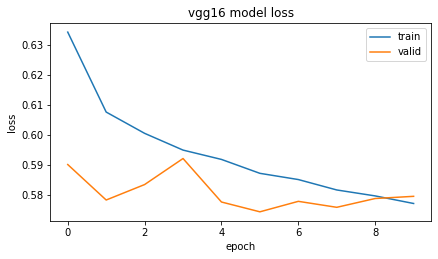

In [ ]:
import matplotlib.pyplot as plt  

plt.figure(1, figsize = (15,8))  
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('vgg16 model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

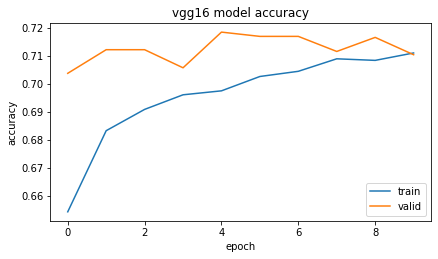

In [ ]:
plt.figure(1, figsize = (15,8))  
    
plt.subplot(222)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('vgg16 model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

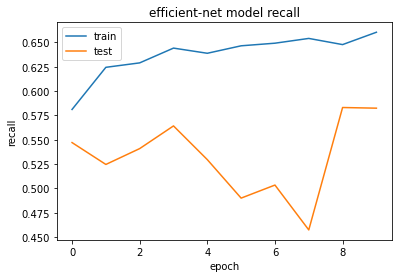

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

plt.title('efficient-net model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

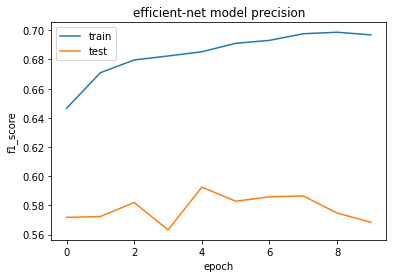

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])

plt.title('efficient-net model precision')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("vgg16_adam.h5")
model.save_weights('vgg16_weights_adam.h5')

In [ ]:
pred = model.predict(test_tensors)


2022-06-30 05:56:08.916232: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 556400640 exceeds 10% of free system memory.
2022-06-30 05:56:09.529136: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 556400640 exceeds 10% of free system memory.


In [ ]:
pred = np.argmax(pred,axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
x = accuracy_score(pred,test_labels)

In [ ]:
x # Accuracy Score

0.5106007067137809